In [1]:
import itertools
import math
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.style as style
import scipy.stats as stats
import seaborn as sns
#%matplotlib notebook
style.use('bmh') ## style for charts

from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

### Future Enhancements:
- regression
- muticlass
- smart toggle log of numericals (maybe if sd > mean * n)
- expand log transforms to all numeric charts
- optional exclude list
- 
- optional list of features to plot exclusivly
- allow lists to be passed to log_transform attributes
- smart annotate heat and corr maps depening on size


In [11]:
class ClassificationEDA:
    def __init__(
        self, 
        df, 
        target,
        max_categories=None, 
    ):
        if df[target].nunique() != 2: raise ValueError('Target must have 2 unique values')
        if max_categories and max_categories < 2: raise ValueError('Max categories must be greater than 1')
        
        DEFAULT_MAX_CATEGORIES = 20
        
        numeric_feats = df.select_dtypes(include=['int64', 'float64']).columns
        categorical_feats = df.select_dtypes(include=['object','bool','category']).columns
        numeric_feats = numeric_feats[numeric_feats != target]
        categorical_feats = categorical_feats[categorical_feats != target]
        
        self.target = target
        self.numeric_features = numeric_feats
        self.categorical_features = categorical_feats
        self.max_categories = max_categories if max_categories is not None else DEFAULT_MAX_CATEGORIES
        self.df = self._clean_df(df)
        self._ranked_numeric_feats = self._rank_numeric_features()
        self._ranked_categorical_feats = self._rank_categorical_features()
        self._bar_lineplot_reference = None
                
    def _clean_df(self, df):
        df[self.target] = pd.get_dummies(df[self.target], drop_first=True)
        
        all_features = np.concatenate([self.numeric_features,self.categorical_features,[self.target]])
        df = df[all_features] #remove any non-numeric, non-categorical fields (ie dates)
        for col in self.categorical_features:
            df[col].fillna("Unknown", inplace = True)
            top_categories = df[col].value_counts().nlargest(self.max_categories-1).index
            df.loc[~df[col].isin(top_categories), col] = "Other(Overflow)"
        
        return df
    
    def _rank_numeric_features(self):
        correlations = [(feat, abs(self.df[self.target].corr(self.df[feat]))) for feat in self.numeric_features]
        correlations.sort(key=lambda tup: tup[1], reverse=True)
        ranked_numeric_features = [feat_corr[0] for feat_corr in correlations]
        
        return ranked_numeric_features
    
    def _rank_categorical_features(self):
        ### Run a small batch of logistic regression with each categorical feature to find significance
        sample_df = self.df.copy()
        if self.df.shape[0] > 1000: sample_df = self.df.sample(n=1000)

        feature_scores = []
        for feat in self.categorical_features:
            X = sample_df[feat]
            y = sample_df[self.target]

            X_onehot = pd.get_dummies(sample_df[feat], drop_first=True)

            lr = LogisticRegression(n_jobs=-1, max_iter=999)
            lr.fit(X_onehot,y)
            y_pred = lr.predict(X_onehot)
            acc = accuracy_score(y_pred, y)

            feature_scores.append((feat, acc))

        feature_scores.sort(key=lambda tup: tup[1], reverse=True)
        ranked_categorical_feats = [feat_corr[0] for feat_corr in feature_scores]
        
        return ranked_categorical_feats
    
    def _get_numeric_best_pairs(self, max_plots=40):
    # find how many features are needed to satisfy the max scatter plot parameter
        n=2; m=1;
        while m < max_plots:
            m += n
            n += 1 

        # if there aren't too many numerical proceed with using them all
        if len(self._ranked_numeric_feats) < n: n = len(self._ranked_numeric_feats)

        scatterplot_feats = self._ranked_numeric_feats[0:n]
        weakest_feat = scatterplot_feats[n-1]

        # get all possible pairs 
        scatter_pairs = list(itertools.combinations(scatterplot_feats, 2))

        while len(scatter_pairs) > max_plots:
            i = 0
            for feat_pair in scatter_pairs:
                if feat_pair[0] == weakest_feat or feat_pair[1] == weakest_feat:
                    break
                i += 1
            scatter_pairs.pop(i)

        return scatter_pairs   
    
    def _get_best_numeric_categorical_pairs(self, max_plots=40):
        ### Find best pairs of numeric and categorical features based on correlation and logistic regression score
        num_categoricals = math.ceil(math.sqrt(max_plots))
        if num_categoricals > len(self.categorical_features): num_categoricals = len(self.categorical_features) 
        
        num_numeric = math.ceil(max_plots/num_categoricals)
        if num_numeric > len(self.numeric_features): num_numeric = len(self.numeric_features) 

        categorical_pair_feats = self._ranked_categorical_feats[0:num_categoricals]
        numeric_pair_feats = self._ranked_numeric_feats[0:num_numeric]        
        weakest_numeric_feat = numeric_pair_feats[num_numeric-1]

        categorical_numeric_pairs = [pair for pair in itertools.product(numeric_pair_feats, categorical_pair_feats)]
        ## if over max_plots limit, pop off pairs with the worst numerical feature one at a time
        while len(categorical_numeric_pairs) > max_plots:
            i = 0
            for feat_pair in categorical_numeric_pairs:
                if feat_pair[0] == weakest_numeric_feat or feat_pair[1] == weakest_numeric_feat:
                    break
                i += 1
            categorical_numeric_pairs.pop(i)

        return categorical_numeric_pairs
            
    def _get_categorical_best_pairs(self, max_plots=50):
        # find how many features are needed to satisfy the max scatter plot parameter
        n=2; m=1;
        while m < max_plots:
            m += n
            n += 1 

        # if there aren't too many numerical proceed with using them all
        if len(self._ranked_categorical_feats) < n: n = len(self._ranked_categorical_feats)

        cat_pair_feats = self._ranked_categorical_feats[0:n]
        weakest_feat = cat_pair_feats[n-1]

        # get all possible pairs 
        cat_pairs = list(itertools.combinations(cat_pair_feats, 2))

        while len(cat_pairs) > max_plots:
            i = 0
            for feat_pair in cat_pairs:
                if feat_pair[0] == weakest_feat or feat_pair[1] == weakest_feat:
                    break
                i += 1
            cat_pairs.pop(i)

        return cat_pairs
    
    
    def plot_ovelayed_barchart(self, field, verbose=False):
        ### Charts the counts of caterogical feats with % of binary response overlaid
        field_count  = self.df[field].value_counts()
        field_count_df = field_count.to_frame()
        field_count_df.columns = ['count']

        # Get the % target by category for the line overlay
        field_target_pct = pd.crosstab(self.df[field], self.df[self.target], normalize='index') * 100
        field_target_pct = field_target_pct.reset_index()
        # Try to choose the axis with smaller values to avoid skewed axis
        if not self._bar_lineplot_reference:
            self._bar_lineplot_reference = 1 if field_target_pct[0].median() < field_target_pct[1].median() else 2
        drop_index = self._bar_lineplot_reference
        field_target_pct = field_target_pct.drop(field_target_pct.columns[-drop_index],axis=1)

        merged_filed_target_pct = field_target_pct.merge(field_count_df, right_index=True, left_on=field)
        field_target_data = merged_filed_target_pct.sort_values('count', ascending=False).reset_index(drop=True)
        field_target_data.sort_values('count', ascending=False).reset_index(drop=True)
        
        if verbose: print(field_target_data)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_xlabel(field)
        ax = sns.barplot(
            field_target_data[field], 
            field_target_data['count'], 
            alpha=0.8
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_ylabel('count (bars)')
        ax2 = ax.twinx()
        ax2 = sns.pointplot(
            x=field_target_data[field], 
            y=field_target_data.iloc[:,-2], 
            color='black', 
            legend=False
        )
        ax2.set_ylabel('% {t} (line)'.format(t = self.target))
        plt.show()
        
        
    def plot_categorical(self, verbose=False):
        if len(self.categorical_features) == 0: raise ValueError('No categorical features!')
        
        feat_count = len(self.categorical_features)
        plt.figure(figsize=(10, 6*feat_count))
        for feat in self.categorical_features:
            self.plot_ovelayed_barchart(feat, verbose)
            
            
    def plot_numeric(self, bins=25, log_transform=False):
        if len(self.numeric_features) == 0: raise ValueError('No numeric features!')
        plot_df = self.df.copy()

        feat_count = len(self.numeric_features)
        target_value0 = plot_df[self.target].value_counts().index[0]
        target_value1 = plot_df[self.target].value_counts().index[1]

        f, axes = plt.subplots(feat_count,figsize=(10, 6*feat_count))

        for i, feat in enumerate(self.numeric_features):
            feat_name = feat
            if log_transform:
                if min(plot_df[feat]) >= 0:
                    plot_df[feat] = np.log10(plot_df[feat] + 1)
                    feat_name = 'log_{f}'.format(f=feat)
            
            sns.distplot(
                plot_df.loc[plot_df[self.target] == target_value0][feat],
                label=target_value0, 
                bins = bins, 
                ax=axes[i]
            )
            sns.distplot(
                plot_df.loc[plot_df[self.target] != target_value0][feat],
                label=target_value1, 
                bins = bins, 
                ax=axes[i]
            )
            axes[i].legend(loc='upper right')
            axes[i].set_title('{f} histogram'.format(f=feat_name))
    
    
    def plot_scatterplots(self, alpha=0.6, log_transform=False, max_plots=40):
        if len(self.numeric_features) < 2: raise ValueError('Need at least 2 numeric features for scatterplots')


        scatter_pairs = self._get_numeric_best_pairs(max_plots=max_plots)
        f, axes = plt.subplots(len(scatter_pairs),figsize=(10, 6*len(scatter_pairs)))
        
        for i, pair in enumerate(scatter_pairs):
            plot_df = self.df.copy()[[pair[0], pair[1], target]]
            
            logf0 = ''
            logf1 = ''
            
            if log_transform:
                if min(plot_df[pair[0]]) >= 0:
                    plot_df[pair[0]] = np.log10(plot_df[pair[0]] + 1)
                    logf0 = 'log_'
                if min(plot_df[pair[1]]) >= 0:
                    plot_df[pair[1]] = np.log10(plot_df[pair[1]] + 1)
                    logf1 = 'log_'
            title = '{p0}{f0} vs {p1}{f1}'.format(p0=logf0, f0=pair[0], p1=logf1, f1=pair[1])
            
            sns.scatterplot(
                data=plot_df, 
                x=pair[0], 
                y=pair[1], 
                hue=self.df[self.target].tolist(), 
                alpha=alpha, 
                ax=axes[i]
            )
            axes[i].set_title(title)
            

    def plot_numeric_categorical_pairs(self, max_plots=40):
        if len(self.categorical_features) == 0: raise ValueError('Need at least 1 categorical feature')
        if len(self.numeric_features) == 0: raise ValueError('Need at least 1 numeric features')
            
        num_cat_pairs = self._get_best_numeric_categorical_pairs(max_plots)
        
        f, axes = plt.subplots(len(num_cat_pairs),figsize=(10, 6*len(num_cat_pairs)))
        for i, pair in enumerate(num_cat_pairs):
            category_count = len(self.df[pair[1]].value_counts())

            if category_count <= 15:
                sns.violinplot(
                    x=pair[1], 
                    y=pair[0], 
                    hue=self.target, 
                    data=self.df, 
                    split=True, 
                    inner='quart', 
                    ax=axes[i]
                )
                axes[i].set_title('{c} vs {n}'.format(c=pair[1],n=pair[0]))
                axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right')
            else:
                sns.boxplot(x=pair[1], y=pair[0], hue=self.target, data=self.df, ax=axes[i])
                axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment='right')
                axes[i].set_title('{c} vs {n}'.format(c=pair[1],n=pair[0]))
                

    def plot_categorical_heatmaps(self, max_plots=50):
        if len(self.categorical_features) < 2: raise ValueError('Need at least 2 categorical features for heatmap')
        categorical_pairs = self._get_categorical_best_pairs(max_plots)
        
        f, axes = plt.subplots(len(categorical_pairs),figsize=(10, 6*len(categorical_pairs)))
        for i, pair in enumerate(categorical_pairs):
            sns.heatmap(pd.pivot_table(self.df,index=[pair[0]], values=self.target, columns=[pair[1]]), ax=axes[i])
            
    def plot_pca(self, output_components=None):
        ## Perform PCA and plot variability described the PCs
        if len(self.numeric_features) < 2: raise ValueError('Need at least 2 numeric features for PCA')
        pca_df = self.df[self.numeric_features].copy()
            
        imp=SimpleImputer(missing_values=np.NaN)
        imp_df=pd.DataFrame(imp.fit_transform(pca_df))
            
        pca = PCA(n_components=imp_df.shape[1])
        pca.fit(imp_df)

        ## Output error explained by sqrt(n)th term
        if not output_components: output_components = math.floor(math.sqrt(imp_df.shape[1]))

        ## Inspect the explained variances to determine how many components to use  
        plt.subplots(figsize=(8, 8))
        # use n_components series to make x axis start at 1
        n_components = pd.Series(range(1,len(np.cumsum(pca.explained_variance_ratio_))+1))
        plt.plot(n_components, np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance');

        ## Output the explained variances at output_components # of components
        output_str = 'Cumulative Explained variance at {n} PCA components:'.format(n=output_components)
        print(output_str,sum(pca.explained_variance_ratio_[0:output_components]) )
    
    def plot_corr_heatmap(self, annot=False):
        if len(self.numeric_features) < 2: raise ValueError('Need at least 2 numeric features for corr heatmap')
        df_numeric = self.df[self.numeric_features]
        sns.heatmap(df_numeric.corr(), annot=annot)

In [12]:
data = pd.read_csv('train_titanic.csv',dtype={'Pclass': 'object'})
data = data.drop(columns=['PassengerId', 'Name'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


<Figure size 720x2160 with 0 Axes>

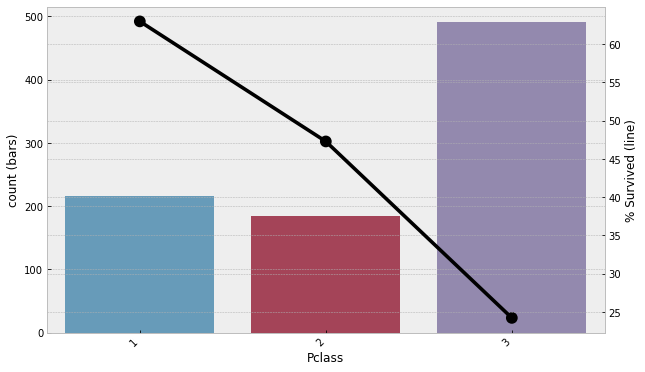

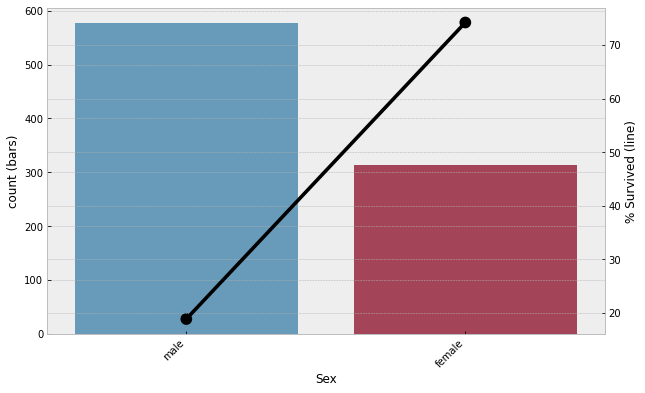

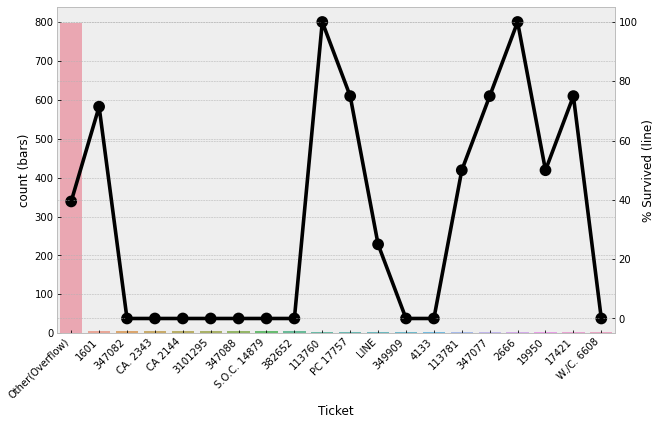

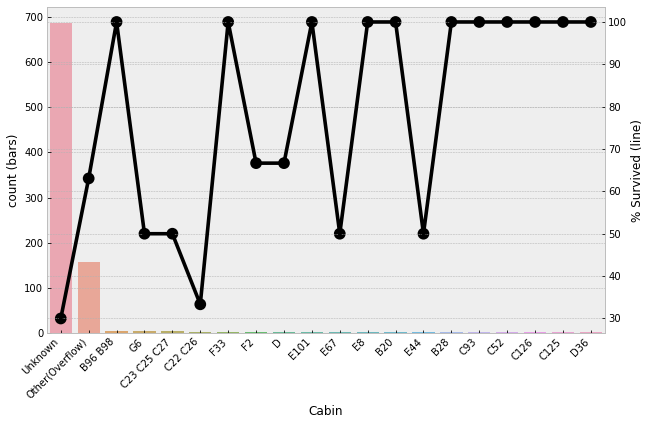

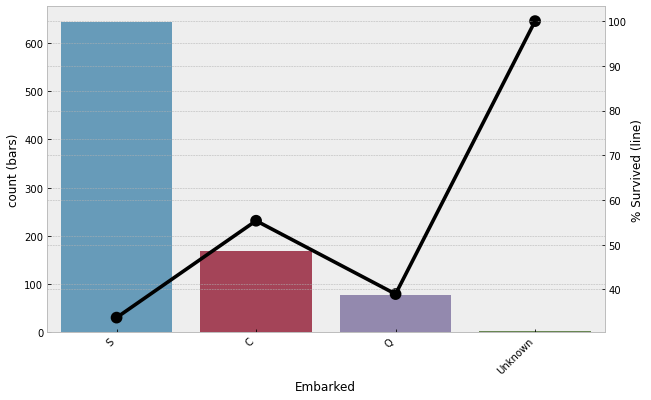

In [13]:
target = 'Survived'
eda = ClassificationEDA(data, target)
eda.plot_categorical()

/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


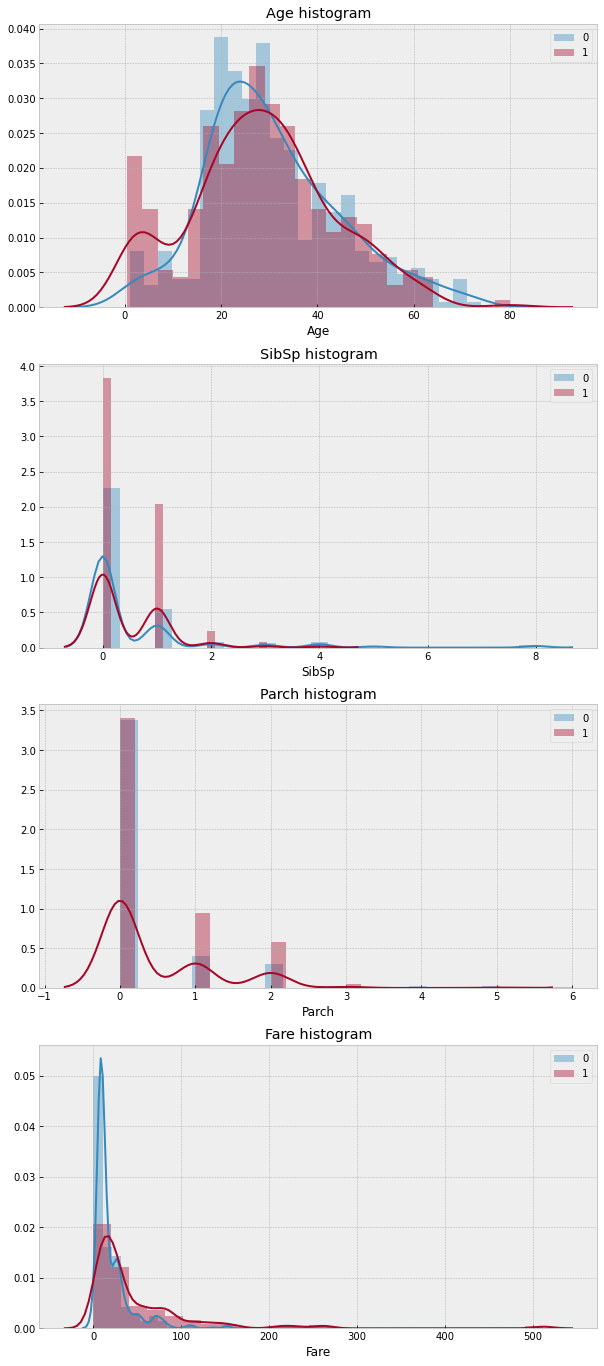

In [14]:
eda.plot_numeric()

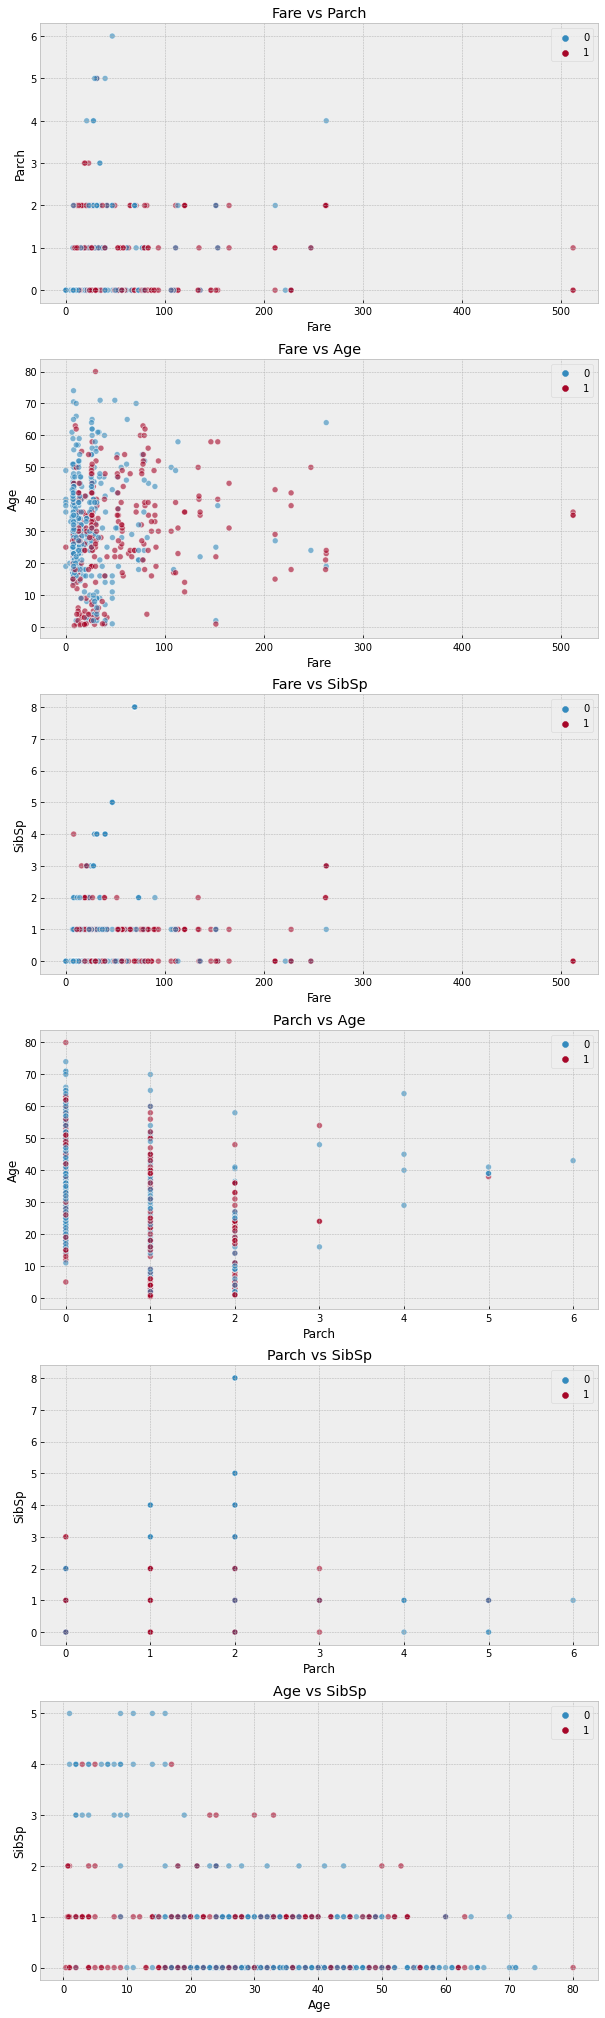

In [15]:
eda.plot_scatterplots()

/opt/anaconda3/envs/msds_rpy37/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


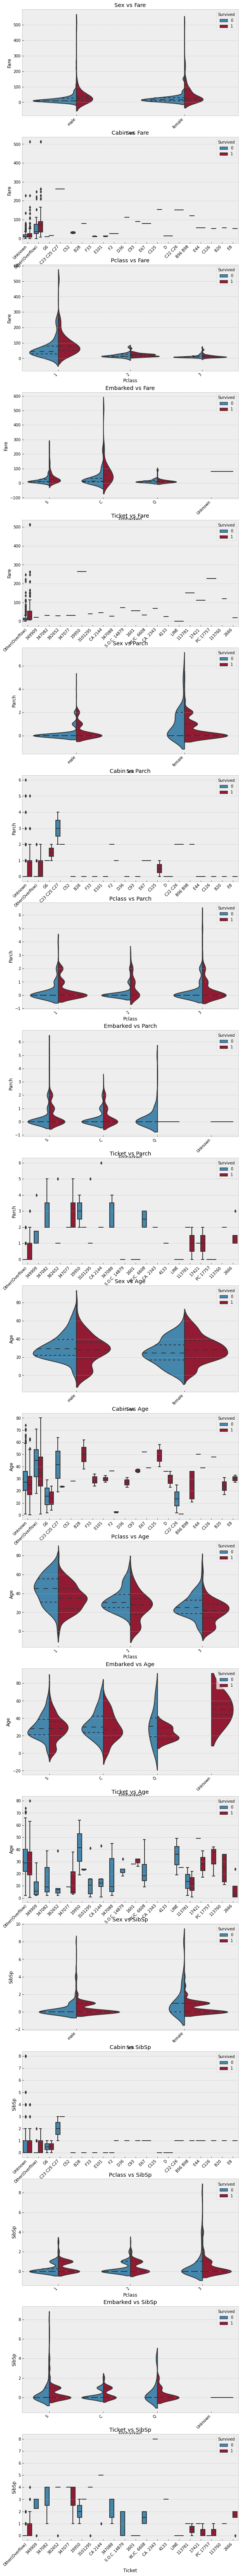

In [16]:
eda = ClassificationEDA(data, target)
eda.plot_numeric_categorical_pairs()

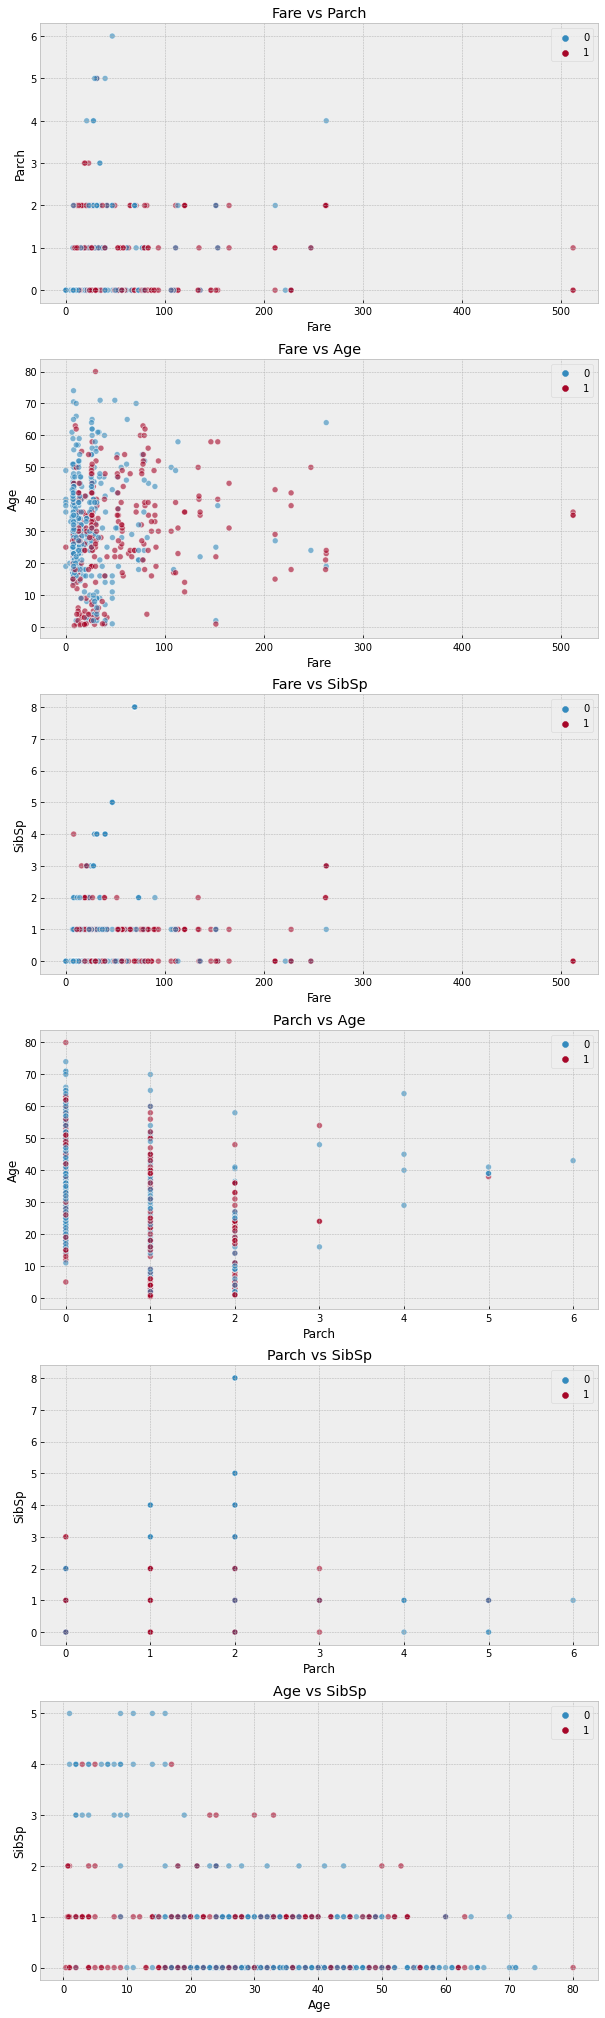

In [17]:
eda.plot_scatterplots()

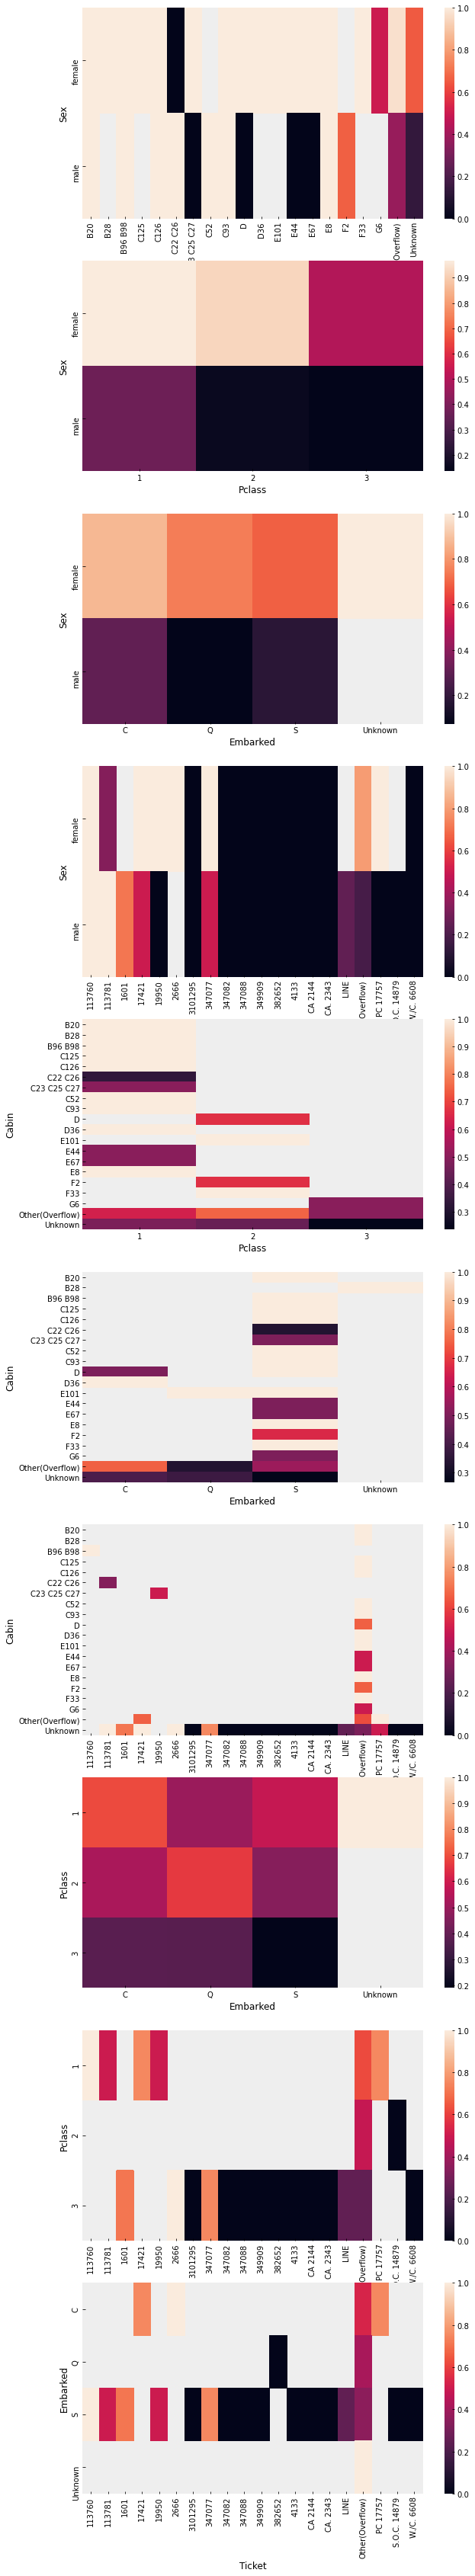

In [18]:
eda.plot_categorical_heatmaps()

Cumulative Explained variance at 2 PCA components: 0.9993551221630402


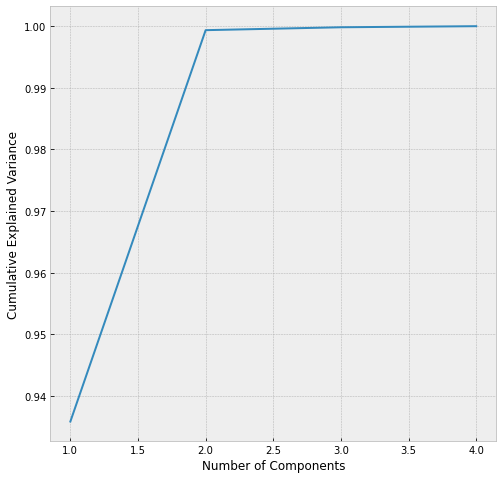

In [19]:
eda.plot_pca()